In [68]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('train.csv')
target = train.Survived.astype('category')
train.drop('Survived', axis=1)

test = pd.read_csv('test.csv')
PassengerId = test.PassengerId


In [69]:
train.head() # train을 위에서 5개 보여줌

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


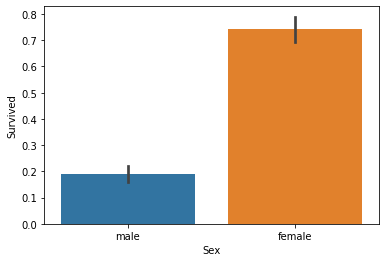

In [70]:
sns.barplot(x='Sex', y='Survived', data=train)

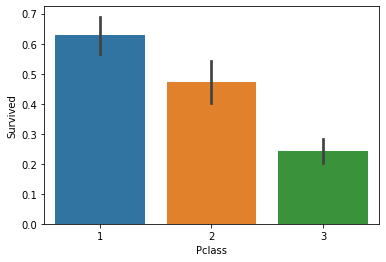

In [71]:
sns.barplot(x='Pclass', y='Survived', data=train)

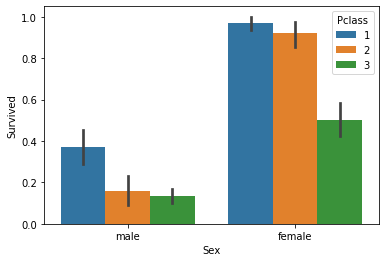

In [72]:
sns.barplot(x='Sex', y='Survived', hue='Pclass', data=train)

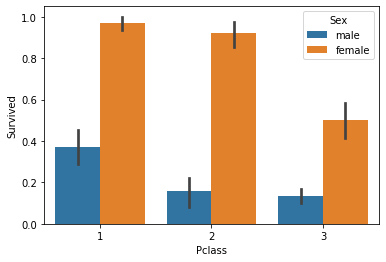

In [73]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train)

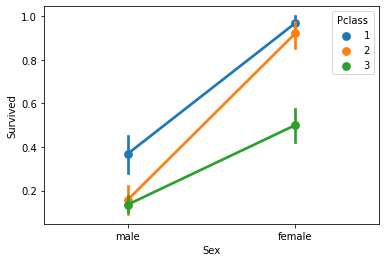

In [74]:
sns.pointplot(x='Sex', y='Survived', hue='Pclass', data=train)

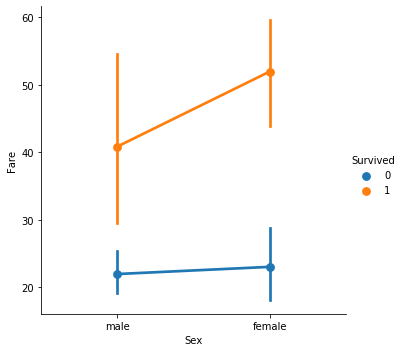

In [75]:
sns.factorplot(x='Sex', y='Fare', hue='Survived', data=train)

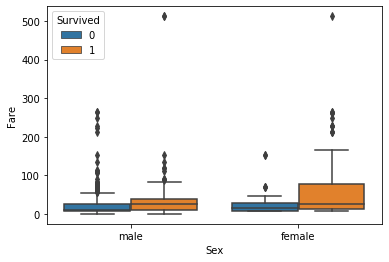

In [76]:
sns.boxplot(x='Sex', y='Fare', hue='Survived', data=train)

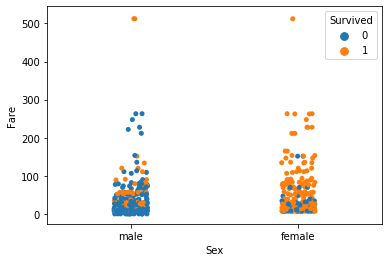

In [77]:
sns.stripplot(x='Sex', y='Fare', hue='Survived', data=train)

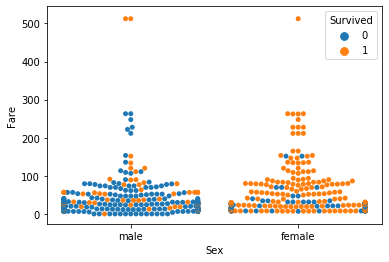

In [78]:
sns.swarmplot(x='Sex', y='Fare', hue='Survived', data=train)

In [79]:
train.shape

(891, 12)

In [80]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [81]:
def get_Titles(df): # 승객의 공통적인 호칭을 묶음
    df.Name = df.Name.apply(lambda name: re.findall("\s\S+[.]\s", name)[0].strip())
    df = df.rename(columns = {'Name': 'Title'})
    df.Title.replace({'Ms.': 'Miss.', 'Mlle.': 'Miss.', 'Dr.': 'Rare', 
                      'Mme.': 'Mr.', 'Major.': 'Rare', 'Lady.': 'Rare', 
                      'Sir.': 'Rare', 'Col.': 'Rare', 'Capt.': 'Rare', 
                      'Countess.': 'Rare', 'Jonkheer.': 'Rare', 'Dona.': 'Rare', 
                      'Don.': 'Rare', 'Rev.': 'Rare'}, inplace=True)
    return df


In [82]:
def fill_Age(df): # Nan값에 승객의 중간 Age로 변환
    df.Age = df.Age.fillna(df.groupby('Title').Age.transform('median'))
    return df

In [83]:
train.Ticket.value_counts()[:10] # 티켓 value의 속한 인원을 체크하여 그들이 일행이라는 것을 확인

1601            7
CA. 2343        7
347082          7
347088          6
CA 2144         6
3101295         6
382652          5
S.O.C. 14879    5
347077          4
LINE            4
Name: Ticket, dtype: int64

In [84]:
train[train.Ticket == 'CA. 2343'] # 같은 티켓 value의 소속된 사람의 last name이 같아 그들이 가족인 것을 확인

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [85]:
train[train.Ticket == '1601'] # 모든 같은 티켓 value를 가진 승객들이 가족이 아니라 같이 여행온 일행이라는 것을 확인

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
74,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S
169,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S
509,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S
643,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S


In [86]:
def get_Group_size(df):
    Ticket_counts = df.Ticket.value_counts()
    df['Ticket_counts'] = df.Ticket.apply(lambda x: Ticket_counts[x])
    df['Family_size'] = df['SibSp'] + df['Parch'] + 1
    df['Group_size'] = df[['Family_size', 'Ticket_counts']].max(axis=1)
    return df

In [87]:
def process_features(df):
    df.Sex = df.Sex.astype('category').cat.codes
    features_to_keep = ['Age', 'Fare', 'Group_size', 'Pclass', 'Sex']
    df = df[features_to_keep]
    return df

In [88]:
def process_data(df):
    df = df.copy()
    df = get_Titles(df)
    df = fill_Age(df)
    df = get_Group_size(df)
    df = process_features(df)
    return df

X_train, X_test = process_data(train), process_data(test)

In [89]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         891 non-null    float64
 1   Fare        891 non-null    float64
 2   Group_size  891 non-null    int64  
 3   Pclass      891 non-null    int64  
 4   Sex         891 non-null    int8   
dtypes: float64(2), int64(2), int8(1)
memory usage: 28.8 KB


In [90]:
X_train.head()

,Age,Fare,Group_size,Pclass,Sex
0,22.0,7.2500,2,3,1
1,38.0,71.2833,2,1,0
2,26.0,7.9250,1,3,0
3,35.0,53.1000,2,1,0
4,35.0,8.0500,1,3,1


In [91]:
correlation_matrix = X_train.corr()
correlation_matrix

,Age,Fare,Group_size,Pclass,Sex
Age,1.000000,0.097947,-0.256371,-0.354189,0.104921
Fare,0.097947,1.000000,0.334278,-0.549500,-0.182333
Group_size,-0.256371,0.334278,1.000000,0.018783,-0.191490
Pclass,-0.354189,-0.549500,0.018783,1.000000,0.131900
Sex,0.104921,-0.182333,-0.191490,0.131900,1.000000


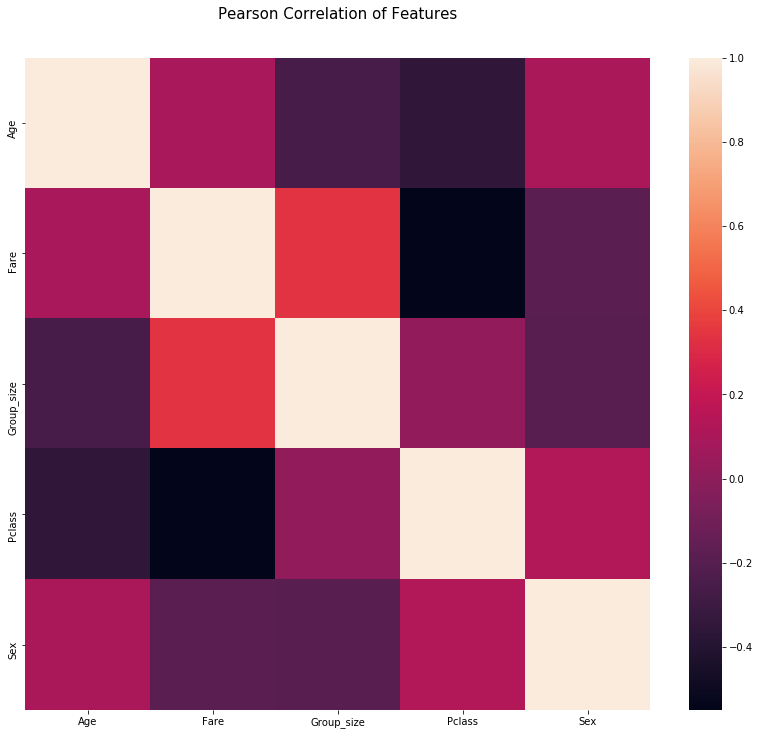

In [92]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(correlation_matrix);

In [93]:
target

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: category
Categories (2, int64): [0, 1]

In [94]:
dtrain = xgb.DMatrix(data=X_train, label=target)
params = {
    "Objective": 'gbtree',
    "eval_metric": 'error',
    "eta" : 0.1 #learning late
}
cv = xgb.cv(params=params, dtrain=dtrain, num_boost_round=100, nfold=5,
            seed=41, early_stopping_rounds= 10)
cv

[12:34:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { Objective } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:34:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { Objective } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:34:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { Objective } might not be used.

  This may not be accurate due to some parameters are only used in language bi

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.130474,0.005873,0.175124,0.035757
1,0.128510,0.005348,0.172877,0.028913
2,0.123459,0.004032,0.172864,0.027973
3,0.115321,0.003840,0.171740,0.029971
4,0.112235,0.006039,0.171734,0.027064
5,0.113637,0.003990,0.170617,0.030796
6,0.115322,0.005671,0.169499,0.029088
7,0.115041,0.005124,0.170623,0.028920
8,0.111391,0.004732,0.169499,0.029088
9,0.108586,0.006788,0.168376,0.026492


In [95]:
def process_data_together(train, test):
    df = pd.concat([train, test], join='inner', keys=['train', 'test']).copy()
    df = get_Titles(df)
    df = fill_Age(df)
    df = get_Group_size(df)
    df = process_features(df)
    return df.loc['train'], df.loc['test']

X_train, X_test = process_data_together(train, test)

In [96]:
xgbcl = XGBClassifier(n_estimators=14, seed=41)
xgbcl.fit(X_train, target)
print(xgbcl.score(X_train, target))

0.8967452300785634


In [97]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         891 non-null    float64
 1   Fare        891 non-null    float64
 2   Group_size  891 non-null    int64  
 3   Pclass      891 non-null    int64  
 4   Sex         891 non-null    int8   
dtypes: float64(2), int64(2), int8(1)
memory usage: 35.7 KB


In [98]:
X_w_target = X_train.copy()
X_w_target['Survived'] = target.astype('int64')
correlation_matrix_w_target = X_w_target.corr()
correlation_matrix_w_target

,Age,Fare,Group_size,Pclass,Sex,Survived
Age,1.000000,0.100406,-0.240819,-0.356113,0.092638,-0.071383
Fare,0.100406,1.000000,0.421812,-0.549500,-0.182333,0.257307
Group_size,-0.240819,0.421812,1.000000,-0.034002,-0.193968,0.074404
Pclass,-0.356113,-0.549500,-0.034002,1.000000,0.131900,-0.338481
Sex,0.092638,-0.182333,-0.193968,0.131900,1.000000,-0.543351
Survived,-0.071383,0.257307,0.074404,-0.338481,-0.543351,1.000000


(<Figure size 432x288 with 3 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x21352bb8408>])

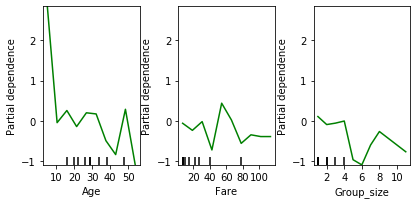

In [99]:
gbcl = GradientBoostingClassifier(learning_rate=0.2, n_estimators=70)
gbcl.fit(X_train, target)
plot_partial_dependence(gbcl, X=X_train, features=[0, 1, 2], 
                        feature_names=['Age', 'Fare', 'Group_size'],
                        grid_resolution=10)

In [100]:
predictions = xgbcl.predict(X_test)
Predictions = pd.DataFrame({'PassengerId': PassengerId, 'Survived': predictions})
submission = pd.read_csv('main_submission.csv')